📌 Setup: Imports & Configuration




In [1]:
import argparse
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from scipy.interpolate import make_interp_spline
from config import CLEANED_TRAIN,MODEL_PATH,VISUALS_DIR

from model_utils import load_and_preprocess, apply_smote

🔍 Helper Functions

In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description="Evaluate trained model and generate plots")
    parser.add_argument("--data", type=str,default=CLEANED_TRAIN, help="Path to same cleaned dataset")
    parser.add_argument("--model", type=str,default=MODEL_PATH, help="Path to trained model file")
    parser.add_argument("--output", type=str,default=VISUALS_DIR, help="Where to save plots")
    return parser.parse_args()

def plot_and_save(fig, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"📷 Saved: {save_path}")

Load data and model

In [4]:
df = load_and_preprocess(CLEANED_TRAIN)
model = joblib.load(MODEL_PATH)

original_labels = df['label']
original_classes = original_labels.unique().astype(str)

dfs = apply_smote(df)  # Balance classes before evaluation
X = dfs.drop('label', axis=1)
y = LabelEncoder().fit_transform(dfs['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)
labels = np.unique(y).astype(str)


📊 plot class distribution

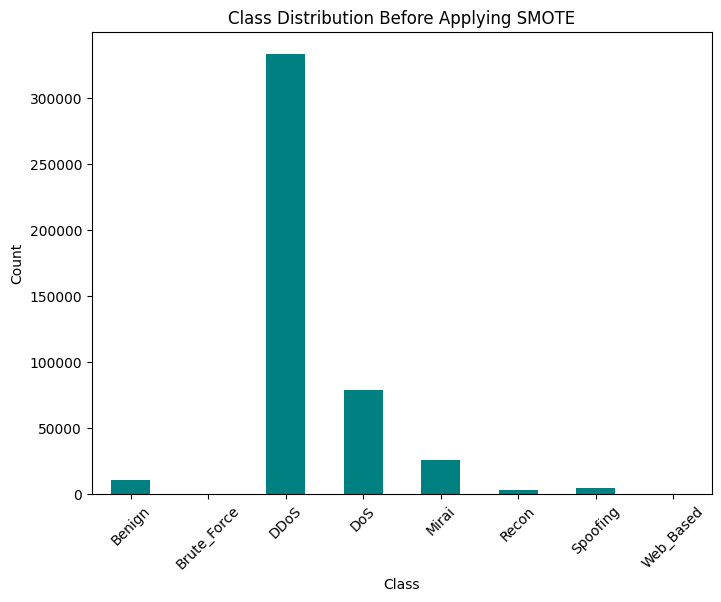

📷 Saved: A:\master\Thesis\Raw_Data\Multi\visualize/label_distribution_before.png


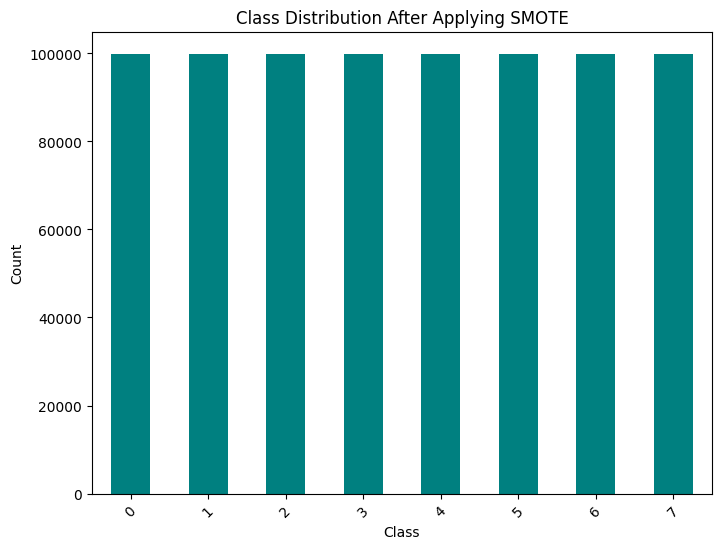

📷 Saved: A:\master\Thesis\Raw_Data\Multi\visualize/label_distribution_after.png


In [5]:
def plot_class_distribution(y, labels, title, path):
    fig, ax = plt.subplots(figsize=(8, 6))
    pd.Series(y).value_counts().sort_index().plot.bar(ax=ax, color='teal')
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plot_and_save(fig, path)

plot_class_distribution(original_labels, original_classes, "Class Distribution Before Applying SMOTE", f"{VISUALS_DIR}/label_distribution_before.png")
plot_class_distribution(y_test, original_classes, "Class Distribution After Applying SMOTE", f"{VISUALS_DIR}/label_distribution_after.png")

📊 plot confusion matrix

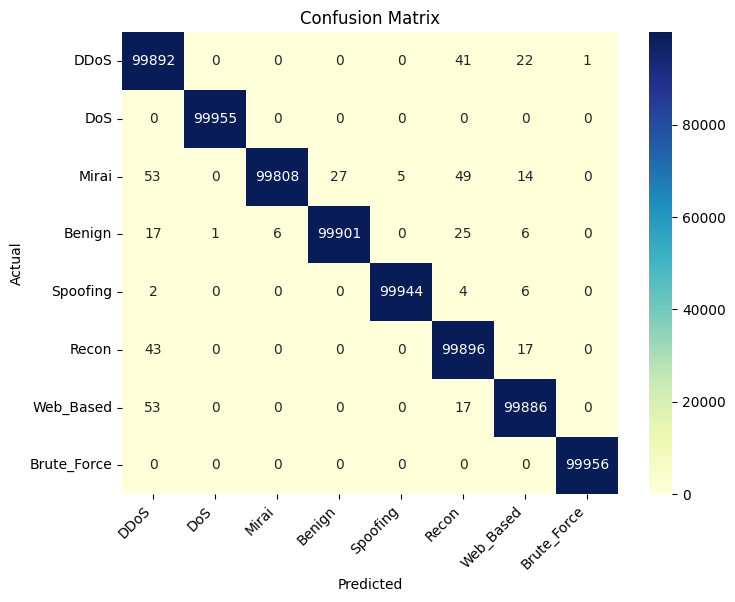

📷 Saved: A:\master\Thesis\Raw_Data\Multi\visualize/confusion_matrix.png


In [6]:
def plot_confusion(y_true, y_pred, labels, save_path):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plot_and_save(fig, save_path)

plot_confusion(y_test, y_pred, original_classes, f"{VISUALS_DIR}/confusion_matrix.png")


📊 plot ROC curve

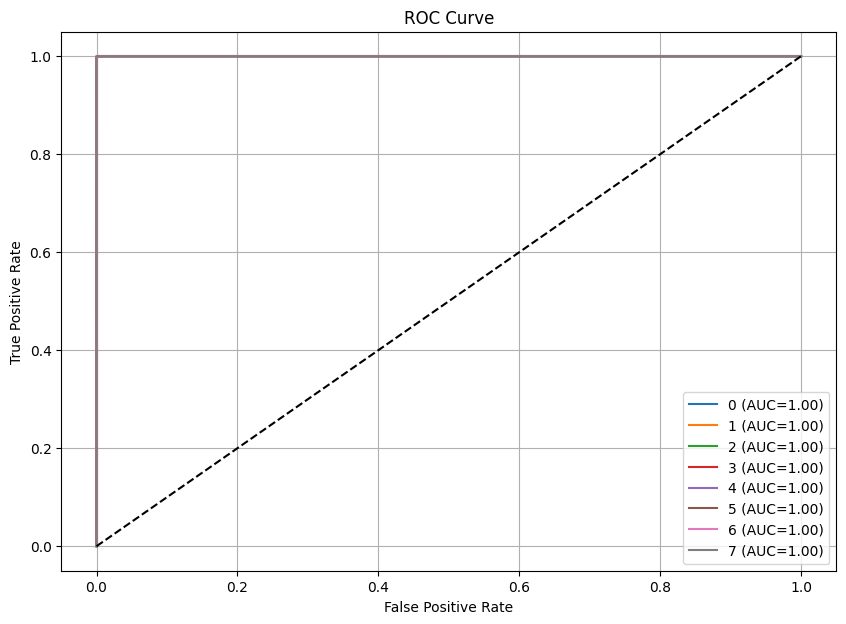

📷 Saved: A:\master\Thesis\Raw_Data\Multi\visualize/roc_curve.png


In [7]:
def plot_roc(y_true, y_score, labels, classes, save_path):
    y_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{labels[i]} (AUC={roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.grid(True)
    plot_and_save(fig, save_path)

plot_roc(y_test, y_score, labels, np.unique(y), f"{VISUALS_DIR}/roc_curve.png")


📊 plot Precesion-Recall curve

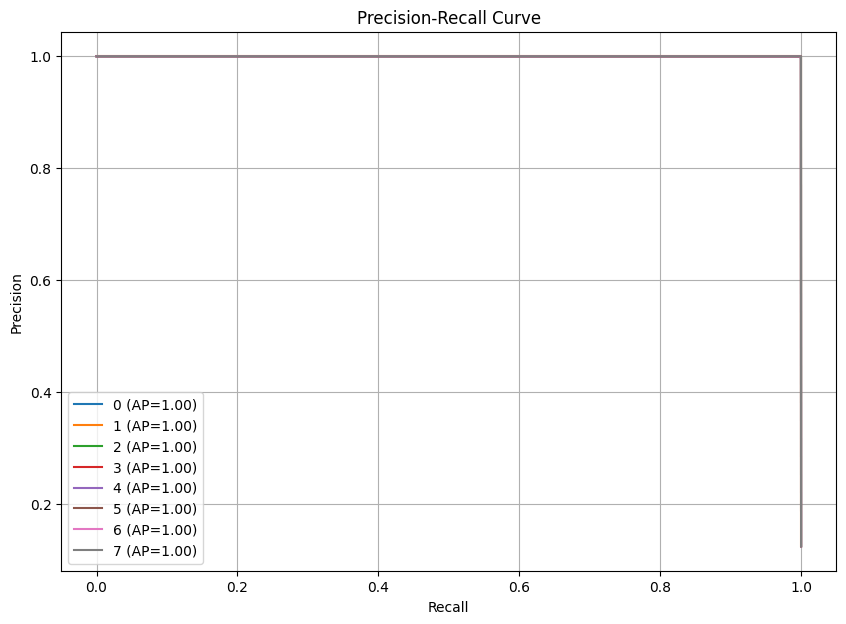

📷 Saved: A:\master\Thesis\Raw_Data\Multi\visualize/pr_curve.png


In [8]:
def plot_pr_curve(y_true, y_score, labels, classes, save_path):
    y_bin = label_binarize(y_true, classes=classes)
    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_bin[:, i], y_score[:, i])
        ax.plot(recall, precision, label=f"{labels[i]} (AP={ap:.2f})")
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    ax.grid(True)
    plot_and_save(fig, save_path)

plot_pr_curve(y_test, y_score, labels, np.unique(y), f"{VISUALS_DIR}/pr_curve.png")


📊 plot Learning curve

In [9]:
def plot_learning(model, X, y, save_path):
    sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5,
                                                     train_sizes=np.linspace(0.1, 1.0, 5),
                                                     scoring='accuracy', n_jobs=-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(sizes, train_scores.mean(axis=1), 'o-', label='Train')
    ax.plot(sizes, val_scores.mean(axis=1), 's-', label='Validation')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Training Size")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)
    plot_and_save(fig, save_path)

plot_learning(model, X, y, f"{VISUALS_DIR}/learning_curve.png")


MemoryError: Unable to allocate 2.03 MiB for an array with shape (533098, 1) and data type float32

📊 plot Calibration curve

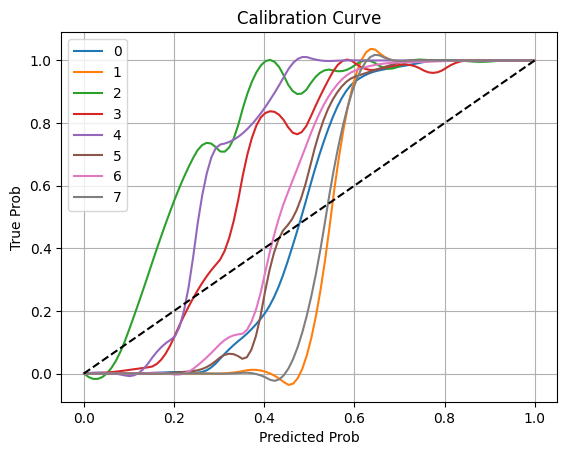

In [10]:
def plot_calibration(y_true, y_score, labels, classes, smooth=False):
    y_bin = label_binarize(y_true, classes=classes)
    for i in range(len(classes)):
        prob_true, prob_pred = calibration_curve(y_bin[:, i], y_score[:, i], n_bins=20)
        if smooth and len(prob_pred) > 2:
            x_smooth = np.linspace(min(prob_pred), max(prob_pred), 100)
            spline = make_interp_spline(prob_pred, prob_true, k=2)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f"{labels[i]}")
        else:
            plt.plot(prob_pred, prob_true, marker='o', label=f"{labels[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Calibration Curve")
    plt.xlabel("Predicted Prob")
    plt.ylabel("True Prob")
    plt.legend()
    plt.grid(True)

plot_calibration(y_test, y_score, labels, np.unique(y), smooth=True)


Classification Report

In [11]:
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))


📋 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99956
           1       1.00      1.00      1.00     99955
           2       1.00      1.00      1.00     99956
           3       1.00      1.00      1.00     99956
           4       1.00      1.00      1.00     99956
           5       1.00      1.00      1.00     99956
           6       1.00      1.00      1.00     99956
           7       1.00      1.00      1.00     99956

    accuracy                           1.00    799647
   macro avg       1.00      1.00      1.00    799647
weighted avg       1.00      1.00      1.00    799647

